### Steps to get a time series prediction working:
* data needs to be stationarised
    * remove trend -> difference (.diff() / integration (calculus))
    * remove variance -> custom transformation (np.log)
    * remove seasonality -> removing the monthly mean - demeaning the data
    * (white noise) - we can't do anything about that, but it's part of time-series
* train/test split
* (create a lag / several lags on our x data, then look for correlations between x and x from a previous time step - THIS IS ONLY REQUIRED FOR sklearn.LinearRegression SOLUTION)
* train and predict with a model
    * naive forecast
    * autoregression (AR)
    * ARIMA

# Adding ARIMA to the equation!
### A function which combines AR with two new parameters - Integration, and Moving Average
* These parameters can be changed to get the best results out of the model
* Works better than AR, its more general.
* Still requires adherence to Auto-Regression assumptions 

$$
y_t = b + \sum_{j=1}^{P}w_{j}Y_{t-j} - \sum_{j=1}^{Q}x_{q}Z_{t-q} + \epsilon_t
$$

$$
where
$$

$$
AR = \sum_{j=1}^{P}w_{j}Y_{t-j}
$$

$$
MA = \sum_{j=1}^{Q}x_{q}Z_{t-q}
$$

$$
Integration = Y_{t-j} - Y_{t}
$$

$$
error = \epsilon_t
$$

$$
bias = b
$$


---

### Three parameters to ARIMA:
* p - autoregressive part (regression on the X data, 0 to 3) - how far back in the past we look
* d - differencing (0 or 1) - 0: actual values, 1: rate of change (detrends linear trend), 2: second order difference (detrends exponential (polynomial) trend) - more than that usually not applicable
* q - moving average part (of the residuals!!, 0 to 3)

---

### Let's recreate pick up our stationarised data, and pass it into ARIMA

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [13]:
df = sns.load_dataset('flights')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


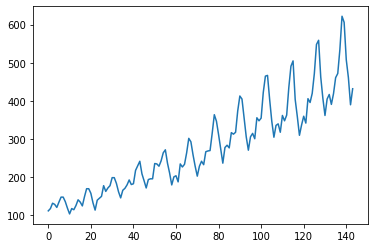

In [15]:
df.passengers.plot()

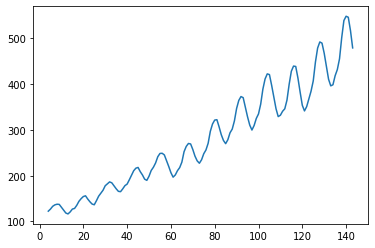

In [16]:
# moving average of passengers just for showing how rolling means work
df.passengers.rolling(window=5).mean().plot()

In [17]:
df['datetime'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['datetime'] = pd.to_datetime(df['datetime'])

In [18]:
df['Date'] = pd.to_datetime(df.month.astype(str) + '-' + df.year.astype(str))
df.set_index('Date', inplace=True)
del df['datetime']
df.head()

,year,month,passengers
Date,,,
1949-01-01,1949,January,112
1949-02-01,1949,February,118
1949-03-01,1949,March,132
1949-04-01,1949,April,129
1949-05-01,1949,May,121


---

## Stationarise the data


* What do we need to remove to ensure stationarity?

#### Trend

In [19]:
df['difference'] = df.passengers.diff() #this is a first order diff, apply for linear plots
# second order diffs will de-trend polynomial plots
# third order and above are rarely needed

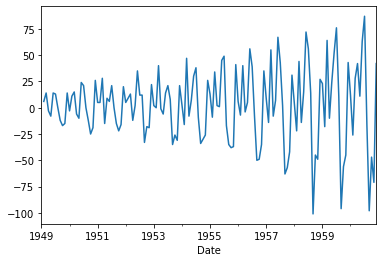

In [21]:
df.difference.plot()

#### Variance

In [22]:
df['log_passengers'] = np.log(df.passengers)

In [23]:
df['diff_log'] = df.log_passengers.diff()

In [25]:
df.fillna(method='bfill', inplace=True) # 'bfill': use next valid observation to fill gap
df.isna().sum()

year              0
month             0
passengers        0
difference        0
log_passengers    0
diff_log          0
dtype: int64

#### Seasonality

In [26]:
df.head()

,year,month,passengers,difference,log_passengers,diff_log
Date,,,,,,
1949-01-01,1949,January,112,6.0,4.718499,0.052186
1949-02-01,1949,February,118,6.0,4.770685,0.052186
1949-03-01,1949,March,132,14.0,4.882802,0.112117
1949-04-01,1949,April,129,-3.0,4.859812,-0.022990
1949-05-01,1949,May,121,-8.0,4.795791,-0.064022


In [27]:
df['monthly_means'] = df.groupby('month')['diff_log'].transform('mean')

In [28]:
df['stationary_passengers'] = df.diff_log - df.monthly_means

In [29]:
df.head()

,year,month,passengers,difference,log_passengers,diff_log,monthly_means,stationary_passengers
Date,,,,,,,,
1949-01-01,1949,January,112,6.0,4.718499,0.052186,0.027407,0.024779
1949-02-01,1949,February,118,6.0,4.770685,0.052186,-0.011986,0.064172
1949-03-01,1949,March,132,14.0,4.882802,0.112117,0.140296,-0.028179
1949-04-01,1949,April,129,-3.0,4.859812,-0.022990,-0.021200,-0.001789
1949-05-01,1949,May,121,-8.0,4.795791,-0.064022,0.007696,-0.071718


In [30]:
#df.apply
#df.transform
## both these functions loop over each element in a pd.series(column of a df),
#and apply a function to the element

---

## Lag the data

In [ ]:
# don't need that for ARIMA

In [31]:
for i in range(1,13):
    df[f'{i}_shift_st_p'] = df.stationary_passengers.shift(i)

In [32]:
feature = ['12_shift_st_p']

---

## Train-test split

In [35]:
#Xtrain = df[:-20][feature] 
#Xtest = df[-20:][feature] 
train = df[:-20]['stationary_passengers']
test = df[-20:]['stationary_passengers']

## Now we can do ARIMA!

In [36]:
from statsmodels.tsa.arima_model import ARIMA

In [56]:
m = ARIMA(train, order=(10,0,5)) # parameters from above in order p,d,q
# 3 days back, 0 difference (we have already done that manually)
# warning if no freq value is set, but thats okay

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [57]:
m_fit = m.fit()

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
output = m_fit.forecast(steps=20) 
# ARIMA version of .predict
# steps: how far into the future to forecast (eg test data = 20 months)

In [59]:
ypred = output[0]
err = output[1] # error
conf = output[2] # confidence

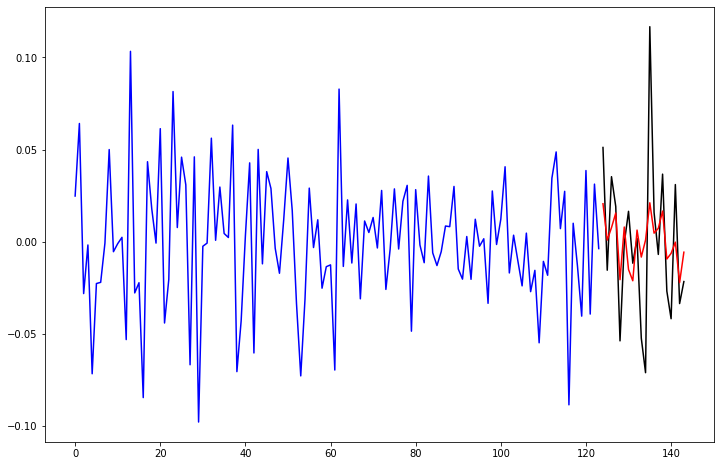

In [60]:
plt.figure(figsize=(12,8))
plt.plot(range(124), train, color='blue')
plt.plot(range(124, 144), test, color='black')
plt.plot(range(124, 144), ypred, color='red')

---

## Reconstruct - Very important!

In [ ]:
#de-trended, de-varianced, and de-seasoned the data. These steps have to be reversed.

In [67]:
original = df[-20:]

In [76]:
# concatenate df[-20:] and ypred
prediction = pd.DataFrame(ypred, index=original.index, columns=['prediction'])
pred = pd.concat([prediction, original], axis=1)

In [77]:
# 1: reseason our data
pred['reseasoned_pred'] = pred.prediction + pred.monthly_means

In [78]:
# 2: retrend our data
pred.loc[pred.index[0], 'reseasoned_pred'] = pred.loc[pred.index[0], 'log_passengers']

In [80]:
# cumulatively sum our data
pred['retrended_pred'] = np.cumsum(pred.reseasoned_pred)

In [81]:
# 3: revariance our data
pred['reconstructed_pred'] = np.exp(pred.retrended_pred)

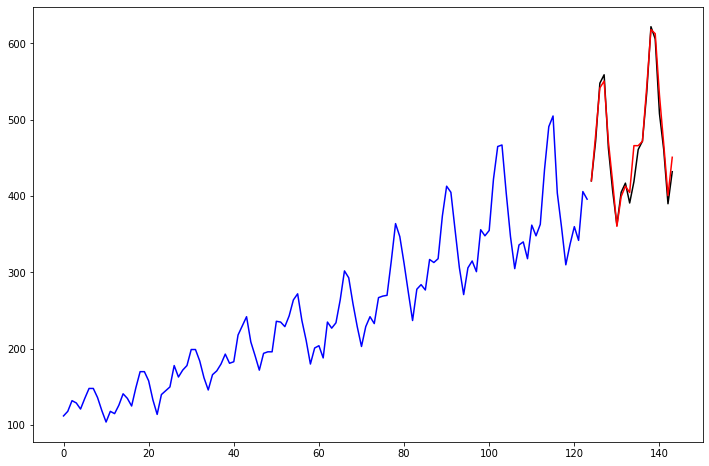

In [83]:
plt.figure(figsize=(12,8))
plt.plot(range(124), df.passengers[:-20], color='blue')
plt.plot(range(124, 144), original.passengers, color='black')
plt.plot(range(124, 144), pred.reconstructed_pred, color='red')

---

### Check auto-correlation

In [ ]:
# !pip install --upgrade statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plot_acf(df.stationary_passengers) #take time lags outside the blue area with high correlation, for best results
None

ACF Plot Explained: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- "Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values **outside** of this code are very likely a correlation and **not** a statistical fluke."
- So basically, the AR model is taking the first 13 time lags because they are highly correlated with the prediction column (no. of passengers) and they are statistically significant.

---

## Checklist!! Apply this to your climate data:
* Stationarise the data
* Build a lag / series of lags
* Make a prediction based on this lag/lags
* Reconstruct - Undo stationarity on the prediction
* Check autocorrelation

---

### Further reading:
* Seasonal decomposition
* Statsmodels AR model
* Facebook Prophet
* non-manual - dickey-fuller, seasonal adjustment

#### Seasonal Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
sdc = seasonal_decompose(Xtrain, period=12, model='additive')
sdc.plot()
None

#### Statsmodel AR

In [ ]:
from statsmodels.tsa.ar_model import AR

ar = AR(df['passengers'])
ar_fitted = ar.fit()
ar_fitted.predict(end='1968')
ypred = ar_fitted.predict(end='1968')
plt.plot(ypred)
plt.plot(df['passengers'])

#### FB Prophet 

- https://facebook.github.io/prophet/docs/quick_start.html#python-api

#### Non-manual

- https://en.wikipedia.org/wiki/Seasonal_adjustment
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html